Bayesian Network is a class of Probabilistic Graphical Models which are a powerfull tool to model interactions between different variables in a model. Some of the most common applications of graphical models can be found in computer vision, signal processing, coding theory. There can be different graph estimation problems. Sometimes, we are given the graph structure and we need to estimate graph parameters. In some cases, we need to estimate graph structure along with graph parameters.

In this notebook, we are trying to estimate a Bayesian Network from given data. First we estimate undirected graph from the data. We experiment with Correlation, Partial Correlation and Mutual Information to estimate the edges. Infact, correlation metric is very common in modelling interactions between different variables. However, we show that partial correlation metric significantly beats correlation and mutual information metric because it takes out the effect of all other variables.

Next we estimate directed skeleton using immorality prediction and rule propagation. We use conditional mutual information as a measure of independence between different variables.

In [1]:
%reset
import numpy as np
from sklearn.metrics import mutual_info_score
from scipy.stats.stats import pearsonr
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import scipy as sc
from pyitlib import discrete_random_variable as drv
import importlib
import matplotlib.pyplot as plt
import itertools
from pgmpy.estimators import ConstraintBasedEstimator

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# Function to generate data from a conditional probability distribution

def generate_conditional(P, X, Y, size):
    Z = np.zeros(size)
    
    if (len(Y) > 0):
        for i in range(len(Z)):
            if (Y[i] == 0):
                if (X[i] == 0):
                    Z[i] = np.random.choice(a = [0, 1], size = 1, p=[1 - P[0], P[0]])
                else:
                    Z[i] = np.random.choice(a = [0, 1], size = 1, p=[1 - P[1], P[1]])
            else:
                if (X[i] == 0):
                    Z[i] = np.random.choice(a = [0, 1], size = 1, p=[1 - P[2], P[2]]);
                else:
                    Z[i] = np.random.choice(a = [0, 1], size = 1, p=[1 - P[3], P[3]]);
    else:
        for i in range(len(Z)):
            if (X[i] == 0):
                Z[i] = np.random.choice(a = [0, 1], size = 1, p=[1 - P[0], P[0]])
            else:
                Z[i] = np.random.choice(a = [0, 1], size = 1, p=[1 - P[1], P[1]]);
        
    return Z

In [3]:
# Function to construct Bayesian Network for data generation

def generate_samples(sample_size):
    A = np.random.choice(a = [0, 1], size = sample_size, p=[0.1, 0.9])
    B = np.random.choice(a = [0, 1], size = sample_size, p=[0.85, 0.15])

    P = [0.1, 0.9, 0.8, 0.2]
    C = generate_conditional(P, A, B, len(A))
    C = C.astype(int)

    P = [0.1, 0.85]
    D = generate_conditional(P, C, [], len(C))
    D = D.astype(int)

    P = [0.75, 0.25]
    E = generate_conditional(P, C, [], len(C))
    E = E.astype(int)

    P = [0.25, 0.85, 0.75, 0.9]
    G = generate_conditional(P, D, E, len(D))
    G = G.astype(int)

    P = [0.1, 0.9, 0.8, 0.1]
    F = generate_conditional(P, D, G, len(D))
    F = F.astype(int)
    
    P = np.row_stack((A,B,C,D,E,F,G))
    
    return P

In [4]:
# Correlation Matrix of data

def generate_correlation_matrix(P):
    Correlation_Matrix = np.corrcoef(P)
    Correlation_Matrix = np.around(Correlation_Matrix, decimals=3)
    return Correlation_Matrix

In [5]:
# Partial Correlation Matrix of data

def generate_partial_correlation_matrix(P, Correlation_Matrix):
    Partial_Correlation_Matrix = np.linalg.inv(Correlation_Matrix)
    Partial_Correlation_Matrix = np.around(Partial_Correlation_Matrix, decimals=3)
    return Partial_Correlation_Matrix

In [6]:
# Mutual Information Matrix of data

def generate_mutual_info_matrix(P):
    Mutual_Info_Matrix = drv.information_mutual(P)
    Mutual_Info_Matrix = np.around(Mutual_Info_Matrix, decimals=3)
    return Mutual_Info_Matrix

In [7]:
# Function to count True (False) Positives (Negatives)

def TPR_FPR(edges_true, edges_predicted):
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for edge in edges_predicted:
        if edge in edges_true and edges_predicted[edge] == 1:
            TP += 1
            continue
        if edge not in edges_true and edges_predicted[edge] == 1:
            FP += 1
            continue
        if edge in edges_true and edges_predicted[edge] == 0:
            FN += 1
            continue
        if edge not in edges_true and edges_predicted[edge] == 0:
            TN += 1
            continue
        
    TPR = TP/(TP + FN)
    FPR = FP/(FP + TN)
    
    return TPR, FPR

In [8]:
# Function to calculate area under the curve of an ROC curve

def ROC_AUC(TPR,FPR):
    AUC = 0
    for i in range(1,len(TPR)):
        AUC = AUC + 0.5*(TPR[i-1] + TPR[i])*(FPR[i-1] - FPR[i])
    
    return AUC

In [9]:
# Function to compute different points of ROC Curve

def ROC_Analysis(Matrix,vertices,edges_undirected_true,method = "",plot_fig = 0):
    threshold = np.linspace(0, np.max(Matrix), num = 100)
    
    TPR = np.zeros(len(threshold))
    FPR = np.zeros(len(threshold))

    for l in range(len(threshold)):
        edges_undirected_predicted = predict_edges(Matrix,vertices,threshold[l])
        
        TPR[l], FPR[l] = TPR_FPR(edges_undirected_true,edges_undirected_predicted)
    
    if plot_fig:
        %pylab
        %matplotlib inline
        plt.plot(FPR, TPR, '-*')
        plt.xlabel("False Positve Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve using %s method" %method)
        plt.grid()
        plt.show()
        
    AUC = ROC_AUC(TPR,FPR)
        
    return AUC

In [10]:
# Function to compute ROC Statistics for different methods

def ROC_Statistics(Iterations,sample_size,vertices,edges_undirected_true):

    AUC_Corr = np.zeros(Iterations)
    AUC_Mutual_Info = np.zeros(Iterations)
    AUC_Partial_Corr = np.zeros(Iterations)

    for i in range(Iterations):

        P = generate_samples(sample_size)

        Correlation_Matrix = generate_correlation_matrix(P)
        Partial_Correlation_Matrix = generate_partial_correlation_matrix(P, Correlation_Matrix)
        Mutual_Info_Matrix = generate_mutual_info_matrix(P)

        AUC_Corr[i] = ROC_Analysis(Correlation_Matrix,vertices,edges_undirected_true)
        AUC_Partial_Corr[i] = ROC_Analysis(Partial_Correlation_Matrix,vertices,edges_undirected_true)
        AUC_Mutual_Info[i] = ROC_Analysis(Mutual_Info_Matrix,vertices,edges_undirected_true)
    
    return AUC_Corr, AUC_Partial_Corr, AUC_Mutual_Info

In [11]:
def strIntersection(s1, s2):
    out = ""
    for c in s1:
        if c in s2 and not c in out:
            out += c
    return out

In [12]:
# Function to calculate Conditional Mutual Information from random variables

def conditional_mutual_information(X,Y,Z):
        
    info_conditional = drv.entropy_joint(np.row_stack((X,Z))) + drv.entropy_joint(np.row_stack((Y,Z))) \
                        - drv.entropy_joint(np.row_stack((X,Y,Z))) - drv.entropy_joint(Z)
        
    return info_conditional

In [13]:
def compute_conditional_mutual_informtion_1(df_data):

    # Conditional Mutual Informtion with 1 witness of independence
    x = 0
    y = 0
    Conditional_mutual_info_array_1 = np.zeros([len(vertices),len(vertices) - 1,len(vertices) - 2])
    for i in range(df_data.shape[1]):
        for j in range(df_data.shape[1]):
            if (j != i):
                for k in range(df_data.shape[1]):
                    if (k != i and k != j):
                        Conditional_mutual_info_array_1[i,x,y] = (conditional_mutual_information\
                                                                              (df_data[str(i+1)].values,\
                                                                               df_data[str(j+1)].values,\
                                                                               df_data[str(k+1)].values))
                        y = y + 1
                y = 0
                x = x + 1
        x = 0
    return Conditional_mutual_info_array_1

In [14]:
def compute_conditional_mutual_informtion_2(df_data):
# Conditional Mutual Informtion with 2 witness of independence
    x = 0
    y = 0
    Conditional_mutual_info_array_2 = np.zeros([7,6,10])
    for i in range(df_data.shape[1]):
        for j in range(df_data.shape[1]):
            if (j != i):
                for k in range(df_data.shape[1]):
                    if (k != i and k != j):
                        for l in range(k, df_data.shape[1]):
                            if (l != i and l != j and l != k):
                                Conditional_mutual_info_array_2[i,x,y] = (conditional_mutual_information\
                                                                                      (df_data[str(i+1)].values,\
                                                                                       df_data[str(j+1)].values,\
                                                                                       np.row_stack((df_data[str(k+1)].values,\
                                                                                                      df_data[str(l+1)].values))))
                                y = y + 1
                y = 0
                x = x + 1
        x = 0
    return Conditional_mutual_info_array_2

In [15]:
def find_witness_of_independence_1(Conditional_mutual_info_array_1,edges_undirected_predicted_PMAP,\
                                  Witness_of_independence, vertices, thresh):
    
    for i in range(len(vertices)):
        for j in range(i+1,len(vertices)):
            for k in range(Conditional_mutual_info_array_1.shape[2]):
                if Conditional_mutual_info_array_1[i,j-1,k] < thresh:
                    edges_undirected_predicted_PMAP[str(vertices[i]) + str(vertices[j])] = 0
                    if vertices[k] >= vertices[j-1]:
                        Witness_of_independence[str(vertices[i]) + str(vertices[j])].append(vertices[k+2])
                    elif vertices[k] >= vertices[i]:
                        Witness_of_independence[str(vertices[i]) + str(vertices[j])].append(vertices[k+1])
                    elif vertices[k] < vertices[i]:
                        Witness_of_independence[str(vertices[i]) + str(vertices[j])].append(vertices[k])    
    
    return Witness_of_independence, edges_undirected_predicted_PMAP

In [16]:
def find_witness_of_independence_2(Conditional_mutual_info_array_2,edges_undirected_predicted_PMAP,\
                                  Witness_of_independence, vertices, thresh, Edge_List):
    
    for i in range(len(vertices)):
        for j in range(i+1,len(vertices)):
            pp = -1
            qq = 0
            for k in range(len(vertices)-2):
                for l in range(k+1,len(vertices)-2):
                    pp += 1
                    if Conditional_mutual_info_array_2[i,j-1,pp] < thresh:
                        edges_undirected_predicted_PMAP[str(vertices[i]) + str(vertices[j])] = 0
                        while(vertices[i] in Edge_List[qq] or vertices[j] in Edge_List[qq]):
                            qq += 1

                        Witness_of_independence[str(vertices[i]) + str(vertices[j])].append(Edge_List[qq])
                        qq += 1    
    
    return Witness_of_independence, edges_undirected_predicted_PMAP

In [17]:
def predict_edges(Matrix,vertices,threshold):
    
    edges_undirected_predicted = {}
    for i in range(Matrix.shape[0]):
        for j in range(i+1,Matrix.shape[1]):
            edges_undirected_predicted[str(vertices[i]) + str(vertices[j])] = 0
            if abs(Matrix[i,j]) > threshold:
                edges_undirected_predicted[str(vertices[i]) + str(vertices[j])] = 1
        
    return edges_undirected_predicted

In [18]:
# function to remove bidirectional edges in estimated Bayesian Network

def remove_bidirectional_edges(edges_predicted_PMAP_Matrix,immoralities_predicted,vertices):
    
    for i in range(edges_predicted_PMAP_Matrix.shape[0]):
        for j in range(i+1,edges_predicted_PMAP_Matrix.shape[1]):
            
            if edges_predicted_PMAP_Matrix[i,j] == 2 and \
            edges_predicted_PMAP_Matrix[j,i] == 2:

                if np.random.choice([0,1]):
                    edges_predicted_PMAP_Matrix[i,j] = 2
                    edges_predicted_PMAP_Matrix[j,i] = 0

                    for entries in immoralities_predicted:
                        if entries[1] == vertices[i] and (entries[0] == vertices[j] or entries[2] == vertices[j]):
                            immoralities_predicted.remove(entries)

                else:
                    edges_predicted_PMAP_Matrix[i,j] = 0
                    edges_predicted_PMAP_Matrix[j,i] = 2

                    for entries in immoralities_predicted:
                        if entries[1] == vertices[j] and (entries[0] == vertices[i] or entries[2] == vertices[i]):
                            immoralities_predicted.remove(entries)
                            
    return edges_predicted_PMAP_Matrix, immoralities_predicted

In [19]:
# Immorality (V-structure) prediction in grpah structure

def get_immorality_prediction(edges_undirected_predicted_PMAP, edges_directed_predicted_PMAP):
    immoralities_predicted = []

    for key_1 in edges_undirected_predicted_PMAP:
        for key_2 in edges_undirected_predicted_PMAP:
            if key_1 != key_2:
                if edges_undirected_predicted_PMAP[key_1] and edges_undirected_predicted_PMAP[key_2]:
                    immoral_node = strIntersection(key_1,key_2)

                    if immoral_node:
                        qq = key_1.replace(immoral_node,"") + key_2.replace(immoral_node,"")
                        immoral_edge = min(qq,qq[::-1])                    
                        if edges_undirected_predicted_PMAP[immoral_edge] == 0 and \
                        not immoral_node in Witness_of_independence[immoral_edge]:                        
                            edges_directed_predicted_PMAP[key_1.replace(immoral_node,"")+immoral_node] = 1
                            edges_directed_predicted_PMAP[key_2.replace(immoral_node,"")+immoral_node] = 1

                            immoralities_predicted.append(min(key_1.replace(immoral_node,"")\
                                                              ,key_2.replace(immoral_node,"")\
                                                             )\
                                                          + immoral_node + \
                                                          max(key_1.replace(immoral_node,"")\
                                                              ,key_2.replace(immoral_node,"")\
                                                             ))

    immoralities_predicted = list(set(immoralities_predicted))
    return immoralities_predicted, edges_directed_predicted_PMAP

In [20]:
# Use of Rule propagation for directionality estimation

def generate_pdag(skel):
    triplets = list(itertools.permutations(range(0,7),3))
    quadruplets = list(itertools.permutations(range(0,7),4))
    while(1):
        change = False
        for t in triplets:
            if(skel[t[0], t[1]] == 2 and skel[t[1], t[2]] == 1 and skel[t[0], t[2]] == 0):
                skel[t[1], t[2]] = 2
                change = True
            if(skel[t[0], t[1]] == 2 and skel[t[1], t[2]] == 2 and skel[t[0], t[2]] == 1):
                skel[t[0], t[2]] = 2
                change = True
        for q in quadruplets:
            if(skel[t[0], t[1]] == 1 and skel[t[0], t[2]] == 1 and skel[t[0], t[3]] == 1\
               and skel[(t[1], t[3])] == 2 and skel[(t[2], t[3])] == 2):
                skel[t[0], t[3]] = 2
                change = True
        if change == False:
            break
    return skel

We are provided with a Bayesian Network. We generate data based on different sample sizes (eg. 50, 100, 500) from the given network. We use Correlation, Partial Correlation and Mutual Information methods to estimate undirected edges. Later, we perform error analysis of these estimated edges with respect to the edges of actual underlying network

In [21]:
edges_undirected_true = ['AC','BC','CD','CE','DG','DF','EG','FG']
vertices = ['A','B','C','D','E','F','G']

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


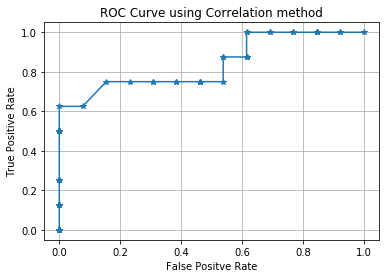

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


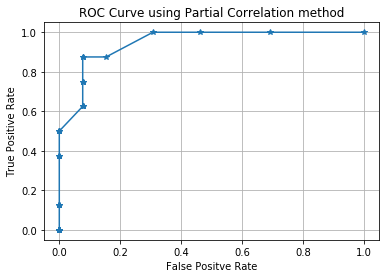

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


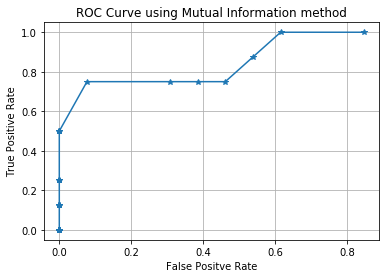

In [22]:
# Undirected Edge Prediction for single sample size of 50, 100 and 500

sample_size = [50,100,500]
sample_size = sample_size[2]

P = generate_samples(sample_size)
Correlation_Matrix = generate_correlation_matrix(P)
Partial_Correlation_Matrix = generate_partial_correlation_matrix(P, Correlation_Matrix)
Mutual_Info_Matrix = generate_mutual_info_matrix(P)

edges_undirected_correlation = predict_edges(Correlation_Matrix, vertices, 0.25)
edges_undirected_partial_correlation = predict_edges(Partial_Correlation_Matrix, vertices, 0.2)
edges_undirected_mutual_info = predict_edges(Mutual_Info_Matrix, vertices, 0.05)

edges_undirected_part_a_b = {}

for edge in edges_undirected_correlation:
    edges_undirected_part_a_b[edge] = []
    edges_undirected_part_a_b[edge].append(edges_undirected_correlation[edge])
    edges_undirected_part_a_b[edge].append(edges_undirected_partial_correlation[edge])
    edges_undirected_part_a_b[edge].append(edges_undirected_mutual_info[edge])
    
_ = ROC_Analysis(Correlation_Matrix,vertices,edges_undirected_true,"Correlation",1)
_ = ROC_Analysis(Partial_Correlation_Matrix,vertices,edges_undirected_true,"Partial Correlation",1)
_ = ROC_Analysis(Mutual_Info_Matrix,vertices,edges_undirected_true,"Mutual Information",1)

In [23]:
edges_undirected_part_a_b

{'AB': [0, 1, 0],
 'AC': [1, 1, 1],
 'AD': [1, 0, 1],
 'AE': [1, 0, 0],
 'AF': [0, 0, 0],
 'AG': [0, 0, 0],
 'BC': [1, 1, 1],
 'BD': [1, 0, 1],
 'BE': [0, 0, 0],
 'BF': [0, 0, 0],
 'BG': [0, 0, 0],
 'CD': [1, 1, 1],
 'CE': [1, 1, 1],
 'CF': [0, 0, 0],
 'CG': [0, 0, 0],
 'DE': [1, 0, 1],
 'DF': [1, 1, 1],
 'DG': [1, 1, 1],
 'EF': [0, 0, 0],
 'EG': [0, 1, 0],
 'FG': [0, 0, 0]}

In [24]:
# ROC Analysis of Edge Predictions

sample_size = [50, 100, 500]

# 50 iterations for statistical evaluation of ROC Curve
Iterations = 50

AUC_Corr_mean = np.zeros(len(sample_size))
AUC_Partial_Corr_mean = np.zeros(len(sample_size))
AUC_Mutual_Info_mean = np.zeros(len(sample_size))

AUC_Corr_std = np.zeros(len(sample_size))
AUC_Partial_Corr_std = np.zeros(len(sample_size))
AUC_Mutual_Info_std = np.zeros(len(sample_size))

for i in range(len(sample_size)):
    AUC_Corr, AUC_Partial_Corr, AUC_Mutual_Info = ROC_Statistics(Iterations,sample_size[i],\
                                                             vertices,edges_undirected_true)
    AUC_Corr_mean[i] = np.mean(AUC_Corr)
    AUC_Corr_std[i] = np.std(AUC_Corr)
    
    AUC_Partial_Corr_mean[i] = np.mean(AUC_Partial_Corr)
    AUC_Partial_Corr_std[i] = np.std(AUC_Partial_Corr)
    
    AUC_Mutual_Info_mean[i] = np.mean(AUC_Mutual_Info)
    AUC_Mutual_Info_std[i] = np.std(AUC_Mutual_Info)

C:\Users\Vineet\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Vineet\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Vineet\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


We can clearly see that Partial Correlation method beats other methods significantly. Partial Correlation method takes out effect of other variables while calculating correlation. This shows that standard correlation and mutual information measures, while doing feature selection, are not appropriate to model interaction between features and labels

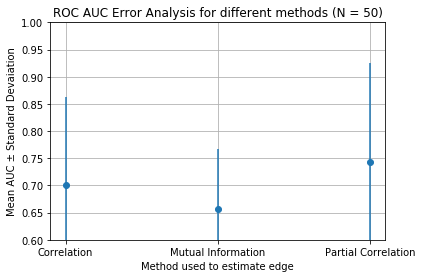

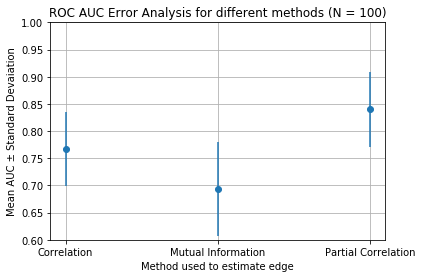

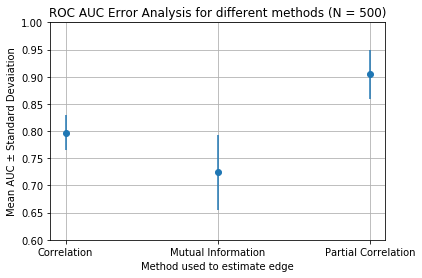

In [25]:
%matplotlib inline
for i in range(len(sample_size)):
    x = ['Correlation', 'Partial Correlation', 'Mutual Information']
    y = [AUC_Corr_mean[i],AUC_Partial_Corr_mean[i],AUC_Mutual_Info_mean[i]]
    yerr = [AUC_Corr_std[i],AUC_Partial_Corr_std[i],AUC_Mutual_Info_std[i]]
    plt.errorbar(x, y, yerr = yerr, fmt='o')
    plt.xlabel("Method used to estimate edge")
    plt.ylabel("Mean AUC ± Standard Devaiation")
    plt.title("ROC AUC Error Analysis for different methods (N = %i)" %sample_size[i])
    axes = plt.gca()
    axes.set_ylim([0.6,1.0])
    plt.grid()
    plt.show()

Till now, we have performed skeleton estimation for an undirected network. Next, we will introduce directionality estimation to our analysis. We start with a completely connected undirected graph and remove edges one by one based on conditional mutual information measure. Later, we construct witness of independence for different node pairs and perform immorality prediction and rule propagation to estimate directed graph skeleton

In [26]:
# Data generation

sample_size = [500, 2500]
P = generate_samples(sample_size[1])

data = {'1': P[0,:], '2': P[1,:], '3': P[2,:], '4': P[3,:], '5': P[4,:], '6': P[5,:], '7': P[6,:]}
df_data = pd.DataFrame(data=data)
del data

In [27]:
# Conditional mutual information evalulation for different node pairs given other nodes

Conditional_mutual_info_array_1 = compute_conditional_mutual_informtion_1(df_data)
Conditional_mutual_info_array_2 = compute_conditional_mutual_informtion_2(df_data)

Conditional_mutual_info_array_1 = np.around(Conditional_mutual_info_array_1, decimals=3)
Conditional_mutual_info_array_2 = np.around(Conditional_mutual_info_array_2, decimals=3)

In [28]:
# Completely connected undirected graph initialization

edges_undirected_predicted_PMAP = {}
Witness_of_independence = {}

for i in range(len(vertices)):
    for j in range(i+1,len(vertices)):
        edges_undirected_predicted_PMAP[str(vertices[i]) + str(vertices[j])] = 1
        Witness_of_independence[str(vertices[i]) + str(vertices[j])] = []
        
Edge_List = list(edges_undirected_predicted_PMAP.keys())

Let us assume, we have 3 nodes A, B and C. There are 3 unique configurations possible A=>B=>C, A<=B=>C and A=>B<=C. 

In first and second structure, A and C are independent given B. However, in third structure (immorality or V-shape), it is other way (A and C are dependent given B). So, we find witness of independence for different node pairs (witness of independence are the conditioned nodes given which different node pairs are independent). Using this information, we estimate directed skeleton of graph

In [29]:
# Witness of independence evaluation for different node pairs

thresh = 0.01

Witness_of_independence, \
edges_undirected_predicted_PMAP = find_witness_of_independence_1(Conditional_mutual_info_array_1,\
                                                                 edges_undirected_predicted_PMAP,\
                                                                 Witness_of_independence, vertices,\
                                                                 thresh)

Witness_of_independence, \
edges_undirected_predicted_PMAP = find_witness_of_independence_2(Conditional_mutual_info_array_2,\
                                                                 edges_undirected_predicted_PMAP,\
                                                                 Witness_of_independence, vertices,\
                                                                 thresh, Edge_List)

In [30]:
edges_predicted_PMAP_Matrix = np.zeros([len(vertices),len(vertices)])

for i in range(len(vertices)):
    for j in range(i+1,len(vertices)):
        if edges_undirected_predicted_PMAP[str(vertices[i]) + str(vertices[j])] == 1:
            edges_predicted_PMAP_Matrix[i,j] = 1
            
for i in range(len(vertices)):
    for j in range(0,i):
            edges_predicted_PMAP_Matrix[i,j] = edges_predicted_PMAP_Matrix[j,i]

In [31]:
# Completely unconnected directed graph initialization

edges_directed_predicted_PMAP = {}

for i in range(len(vertices)):
    for j in range(0,len(vertices)):
        if i != j:
            edges_directed_predicted_PMAP[str(vertices[i]) + str(vertices[j])] = 0

In [32]:
# Immorality Prediction (V-structure)

immoralities_predicted, \
edges_directed_predicted_PMAP = get_immorality_prediction(edges_undirected_predicted_PMAP,\
                                                          edges_directed_predicted_PMAP)

In [33]:
for i in range(len(vertices)):
    for j in range(len(vertices)):
        if i != j and edges_directed_predicted_PMAP[str(vertices[i]) + str(vertices[j])] == 1:
            edges_predicted_PMAP_Matrix[i,j] = 2
        if edges_predicted_PMAP_Matrix[i,j] == 2 and edges_predicted_PMAP_Matrix[j,i] != 2:
            edges_predicted_PMAP_Matrix[j,i] = 0

In [34]:
edges_predicted_PMAP_Matrix, \
immoralities_predicted = remove_bidirectional_edges(edges_predicted_PMAP_Matrix,immoralities_predicted,vertices)

In [35]:
# Directed graph estimation from Rule Propagatiion

edges_predicted_PMAP_Matrix = generate_pdag(edges_predicted_PMAP_Matrix)
edges_predicted_PMAP_Matrix

array([[0., 0., 2., 0., 0., 0., 0.],
       [0., 0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 2., 2., 0., 0.],
       [0., 0., 0., 0., 0., 2., 2.],
       [0., 0., 0., 0., 0., 0., 2.],
       [0., 0., 0., 1., 0., 0., 2.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [36]:
edges_directed_true = ['AC','BC','CD','CE','DF','DG','EG','GF']

edges_true_PMAP_Matrix = np.zeros([len(vertices),len(vertices)])

for i in range(len(vertices)):
    for j in range(len(vertices)):
        if i != j and str(vertices[i]) + str(vertices[j]) in edges_directed_true:
            edges_true_PMAP_Matrix[i,j] = 2

In [37]:
immoralities_true = ['ACB','DFG','DGE']
immoralities_possible = []

for i in range(len(vertices)):
    for j in range(len(vertices)):
        if j != i:
            for k in range(j+1,len(vertices)):
                if k != i and k != j:
                    immoralities_possible.append(vertices[j]+vertices[i]+vertices[k])

In [38]:
# FP and TP for Edges

TP = FP = TN = FN = 0

for i in range(len(vertices)):
    for j in range(len(vertices)):
        if i != j:
            if edges_true_PMAP_Matrix[i,j] == 2 and edges_predicted_PMAP_Matrix[i,j] == 2:
                TP += 1
                continue
            if edges_true_PMAP_Matrix[i,j] == 0 and edges_predicted_PMAP_Matrix[i,j] == 2:
                FP += 1
                continue
            if edges_true_PMAP_Matrix[i,j] == 0 and edges_predicted_PMAP_Matrix[i,j] != 2:
                TN += 1
                continue
            if edges_true_PMAP_Matrix[i,j] == 2 and edges_predicted_PMAP_Matrix[i,j] != 2:
                FN += 1
                continue
                
print ("Edges Predictions")
print ("TP, FP, TN, FN")
print (TP, FP, TN, FN)

Edges Predictions
TP, FP, TN, FN
7 1 33 1


In [39]:
# FP and TP for Immoralities

TP = FP = TN = FN = 0

for immorality in immoralities_possible:
    if immorality in immoralities_true and immorality in immoralities_predicted:
        TP += 1
        continue
    if immorality not in immoralities_true and immorality in immoralities_predicted:
        FP += 1
        continue
    if immorality in immoralities_true and immorality not in immoralities_predicted:
        FN += 1
        continue
    if immorality not in immoralities_true and immorality not in immoralities_predicted:
        TN += 1
        continue

print ("Immorality Predictions")
print ("TP, FP, TN, FN")
print (TP, FP, TN, FN)

Immorality Predictions
TP, FP, TN, FN
2 1 101 1
